In [1]:
import numpy as np
import keras
from math import sqrt
from pandas import read_csv
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

from battdeg import  pl_samples_file_reader

Using TensorFlow backend.


In [2]:
data_dir = '/home/ubuntu_cp/uwdirect/BattDeg/data/PL 12,14'
file_name_format = 'PL12(3).csv'
ignore_file_indices = [1, 2, 3]
df_pl12 = pl_samples_file_reader(data_dir, file_name_format, ignore_file_indices)

dict_keys([4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])


In [3]:
df_pl12.head()

,Time_sec,Date_Time,Step,Cycle,Current_Amp,Voltage_Volt,Charge_Ah,Discharge_Ah,charge_cycle_ah,discharge_cycle_ah,capacity_ah
0,10.000357,735819.421979,1,1,0.0,4.190699,0.0,0.0,0.0,0.0,0.0
1,20.000433,735819.422095,1,1,0.0,4.190699,0.0,0.0,0.0,0.0,0.0
2,30.016045,735819.422211,1,1,0.0,4.190861,0.0,0.0,0.0,0.0,0.0
3,40.031507,735819.422326,1,1,0.0,4.190537,0.0,0.0,0.0,0.0,0.0
4,50.047247,735819.422454,1,1,0.0,4.190861,0.0,0.0,0.0,0.0,0.0


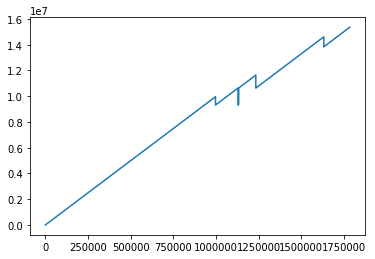

In [4]:
plt.plot(df_pl12['Time_sec'])

In [5]:
# Code inspired from Jason Brownlee's posrt here: 
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

# multivariate multi-step encoder-decoder lstm
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 50, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores


In [16]:
def split_test_train(data, split_ratio):
    """
    This function splits the data into train and test sets based on the ratio provided. 
    
    Parameters: 
        data (Pandas dataframe): This is the dataframe provided. 
        split_ratio (float): A number between 0 and 1. 
    
    Returns:
        Returns the two dataframes in the ratio 
        
    """
    if not isinstance(split_ratio, float):
        raise(TypeError, "The type of split_ratio is not float")

    if (split_ratio < 0) or (split_ratio > 1):
        raise(ValueError, "The split_error value should be between 0 and 1")

    train_length = split_ratio * len(data)
    # split into standard weeks
    train, test = data.iloc[0:round(train_length)], data[round(train_length):]

    return train, test


In [18]:
train_df, test_df = split_test_train(df_pl12, 0.8)

In [21]:
train_df.head()

,Time_sec,Date_Time,Step,Cycle,Current_Amp,Voltage_Volt,Charge_Ah,Discharge_Ah,charge_cycle_ah,discharge_cycle_ah,capacity_ah
0,10.000357,735819.421979,1,1,0.0,4.190699,0.0,0.0,0.0,0.0,0.0
1,20.000433,735819.422095,1,1,0.0,4.190699,0.0,0.0,0.0,0.0,0.0
2,30.016045,735819.422211,1,1,0.0,4.190861,0.0,0.0,0.0,0.0,0.0
3,40.031507,735819.422326,1,1,0.0,4.190537,0.0,0.0,0.0,0.0,0.0
4,50.047247,735819.422454,1,1,0.0,4.190861,0.0,0.0,0.0,0.0,0.0


In [20]:
test_df.head()

,Time_sec,Date_Time,Step,Cycle,Current_Amp,Voltage_Volt,Charge_Ah,Discharge_Ah,charge_cycle_ah,discharge_cycle_ah,capacity_ah
1427431,1.256881e+07,736130.560012,10,852,0.234590,4.200566,901.540525,895.732034,0.877221,0.0,0.877221
1427432,1.256882e+07,736130.560127,10,852,0.232253,4.200404,901.541174,895.732034,0.877870,0.0,0.877870
1427433,1.256883e+07,736130.560243,10,852,0.230455,4.200404,901.541816,895.732034,0.878513,0.0,0.878513
1427434,1.256884e+07,736130.560359,10,852,0.228297,4.200404,901.542454,895.732034,0.879150,0.0,0.879150
1427435,1.256885e+07,736130.560475,10,852,0.226139,4.200566,901.543086,895.732034,0.879782,0.0,0.879782


In [ ]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)
